# 2019 Canadian Election tweets
# OSEMN Step 2: Scrub
# Cleanup of Sentiment 140 dataset
# Removal of duplicates

This notebook describes part of Step 2: Scrub of OSEMN methodology. It covers cleanup of Sentiment 140.

Cleanup plan:

1. Duplicate checks
2. Remove duplicated mislabelled tweets
3. Remove users with high count of tweets (tweeter bots, duplicated posts)

## Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time

sns.set()

In [2]:
from proc_utils import duplicate_check

In [3]:
data_dir = '../../data/sentiment140/'
os.listdir(data_dir)

['sentiment140_train_cleaned.csv',
 'sentiment140_train_nodup.csv',
 'testdata.manual.2009.06.14.csv',
 'training.1600000.processed.noemoticon.csv']

## Load Sentiment 140 dataset

In [4]:
t = time()
df = pd.read_csv(data_dir + 'sentiment140_train_cleaned.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) +
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) +
      "\n-- Column names:\n", df.columns)


----- DataFrame loaded
in 3.54 seconds
with 1,599,306 rows
and 8 columns
-- Column names:
 Index(['sentiment', 'ids', 'date', 'query', 'user', 'text', 'hashtags',
       'handles'],
      dtype='object')


## Duplicate check

### Duplicate check criteria

Duplicate checks have been performed with the following criteria used for detection:

* all columns (entries must match on all columns to be considered duplicated)

* each column excluded one by one from the list, check performed with the rest

* date+user+text (same date, same user, same text)

* user+text (same user, same text)

* id+text (same tweet id, same text)

### Duplicate check results

* there are some misclassified records -- they match in everything, but have different `'class'`

* there are some users with a much higher number of posts than the mean

* there are some twitter bots present in the dataset

* users can post duplicated tweets

Subset 'all_columns': 0 (0.00% of total 1,599,306) records are detected as duplicated.
Subset 'date+user+text': 1,879 (0.12% of total 1,599,306) records are detected as duplicated.
Subset 'user+text': 5,595 (0.35% of total 1,599,306) records are detected as duplicated.
Subset 'id+text': 1,684 (0.11% of total 1,599,306) records are detected as duplicated.


,all_columns,date+user+text,user+text,id+text
num_duplicates,0.0,1.879000e+03,5.595000e+03,1.684000e+03
num_total,1599306.0,1.599306e+06,1.599306e+06,1.599306e+06
percentage,0.0,1.174885e-01,3.498392e-01,1.052957e-01


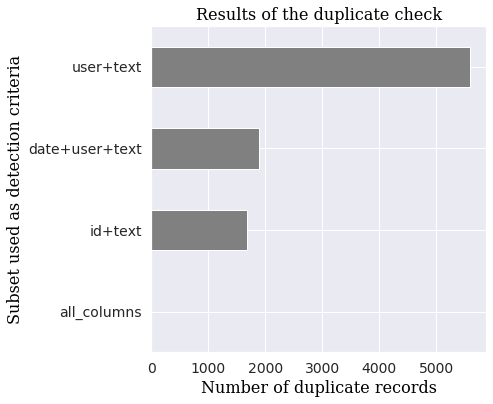

In [5]:
subsets_to_check = {
    'date+user+text': ['date', 'user', 'text'],
    'user+text': ['user', 'text'],
    'id+text': ['ids', 'text']
}

# added columns 'hashtags' and 'handles' are excluded from the check
duplicate_check(df.drop(['hashtags', 'handles'], axis=1), 
                subsets_to_check=subsets_to_check)

## Remove duplicated mislabelled tweets

In [6]:
df.drop('sentiment', axis=1).duplicated().sum()

1684

Duplicate check using all columns (with `'sentiment'` excluded) detects 1684 duplicates -- these pairs of records are identical in everything, but one is classified as "positive", and another one as "negative".

In [7]:
# get the list of 'id's of all rows that have 2 records under the same 'id' 
ids = df['ids'].value_counts()[df['ids'].value_counts() == 2].index
mask = df['ids'].isin(ids)
df[mask].sort_values('user').head(10)

,sentiment,ids,date,query,user,text,hashtags,handles
135660,0,1879941003,2009-05-21 23:36:00,NO_QUERY,007peter,"@NaniWaialeale No, not Keith Olbermann, he ann...",NaN,@NaniWaialeale
999760,4,1879941003,2009-05-21 23:36:00,NO_QUERY,007peter,"@NaniWaialeale No, not Keith Olbermann, he ann...",NaN,@NaniWaialeale
1193803,4,1984377787,2009-05-31 14:59:31,NO_QUERY,15AMR,I'm broke cuz she got all she wanted! Going ho...,NaN,NaN
254966,0,1984377787,2009-05-31 14:59:31,NO_QUERY,15AMR,I'm broke cuz she got all she wanted! Going ho...,NaN,NaN
258264,0,1985150195,2009-05-31 16:32:00,NO_QUERY,19fischi75,@Impala_Guy Yeah this is really annoying - wi...,NaN,@Impala_Guy
469334,0,2176210509,2009-06-15 03:14:01,NO_QUERY,19fischi75,@Impala_Guy SORRY missed again - the boss was ...,NaN,@Impala_Guy
1519893,4,2176210509,2009-06-15 03:14:01,NO_QUERY,19fischi75,@Impala_Guy SORRY missed again - the boss was ...,NaN,@Impala_Guy
1198259,4,1985150195,2009-05-31 16:32:00,NO_QUERY,19fischi75,@Impala_Guy Yeah this is really annoying - wi...,NaN,@Impala_Guy
71982,0,1694107135,2009-05-04 01:06:58,NO_QUERY,26Neil,: I love camp fires I just wish the kids woul...,NaN,NaN
900538,4,1694107135,2009-05-04 01:06:58,NO_QUERY,26Neil,: I love camp fires I just wish the kids woul...,NaN,NaN


In [8]:
mask1 = df.drop('sentiment', axis=1).duplicated()
df = df[~mask1]
print("{0:,} records remaining in the DataFrame.".format(len(df)))


1,597,622 records remaining in the DataFrame.


## Users with a high frequency of tweets

In [9]:
df['user'].value_counts()

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
                  ... 
ChicGeekSpeak        1
francoisproulx       1
MacOgre              1
paulstirling         1
NataliasMom14        1
Name: user, Length: 659459, dtype: int64

In [10]:
df['user'].value_counts().describe()

count    659459.000000
mean          2.422625
std           4.703843
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         549.000000
Name: user, dtype: float64

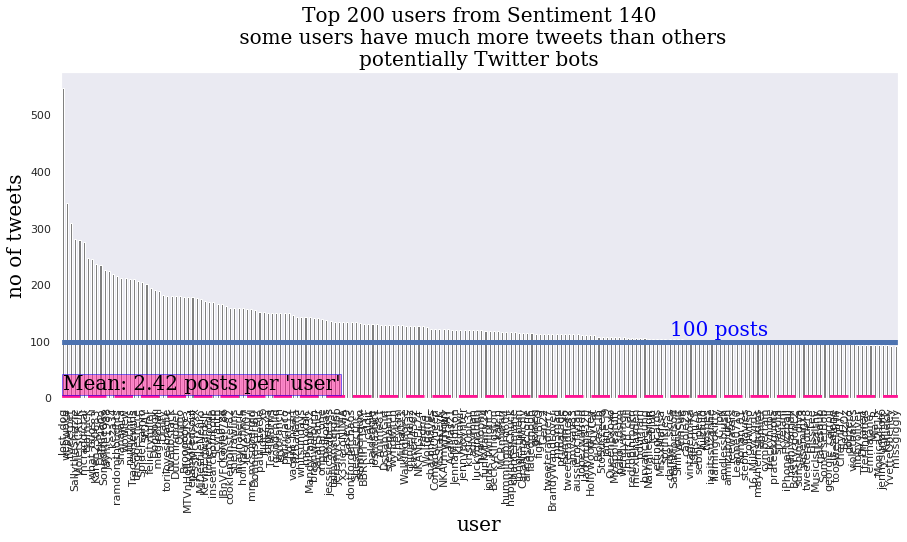

In [11]:
# create figure and axis
f, ax = plt.subplots(1, figsize=(15, 6))
font_mean = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 20,
            }

font_labels = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 20,
               }

# plot value counts for top 30 users by # of records
df['user'].value_counts().head(200).plot(kind='bar', color='gray', ax=ax)

# plot the mean
mean = df['user'].value_counts().mean()
ax.axhline(mean, color='deeppink', linestyle='--', linewidth=5)
ax.text(0, 
        mean * 6, 
        "Mean: {0:.2f} posts per 'user'".format(mean), 
        fontdict=font_mean,
        bbox=dict(facecolor='deeppink', edgecolor='blue', pad=1.0, alpha=0.5))
ax.set_xlabel("user", fontdict=font_labels)
ax.set_ylabel("no of tweets", fontdict=font_labels)
ax.set_title("Top 200 users from Sentiment 140\n \
some users have much more tweets than others\npotentially Twitter bots", fontdict=font_labels)
ax.axhline(100, linewidth=5)
ax.text(145, 110, "100 posts", fontdict={'family': 'serif', 'color': 'blue', 'size':'20'})
plt.grid(False)
f.savefig('results/tweets_per_user.png', bbox_inches='tight')

## Twitter bots
Some of the users with a large number of tweets correspond to tweeter bots.

In [12]:
mask1 = df['user'] == 'tweetpet'
df.loc[mask1, ['date', 'user', 'text']]


,date,user,text
9560,2009-04-17 22:00:01,tweetpet,@tweetchild Clean Me!
9561,2009-04-17 22:00:01,tweetpet,@tweetchild Clean Me!
9562,2009-04-17 22:00:02,tweetpet,@chromachris Clean Me!
9564,2009-04-17 22:00:03,tweetpet,@reatlas Clean Me!
9565,2009-04-17 22:00:03,tweetpet,@chromachris Clean Me!
...,...,...,...
49679,2009-05-02 06:00:37,tweetpet,@amateurdelta54 Clean Me!
49680,2009-05-02 06:00:38,tweetpet,@littleblue62 Clean Me!
49681,2009-05-02 06:00:39,tweetpet,@Shawn1976 Clean Me!
49694,2009-05-02 06:01:02,tweetpet,@TKgFMb hungry. Type 'feed' to feed me...


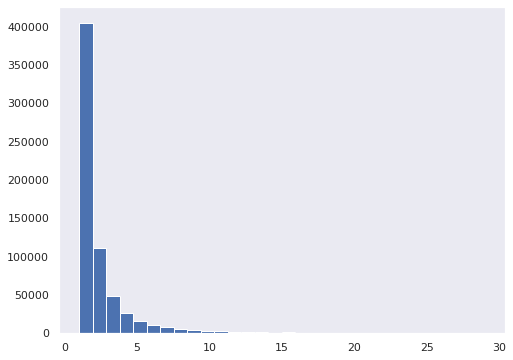

In [13]:
max_tweets = 30
mask1 = df['user'].value_counts() < max_tweets
df['user'].value_counts()[mask1].hist(bins=max_tweets, figsize=(8, 6))
plt.grid(False)

## Remove users with a high frequency of tweets

In [14]:
max_tweets = 15
mask1 = df['user'].value_counts() > max_tweets
num_unique_users = df['user'].nunique()
num_hf_users = mask1.sum()
print("DataFrame contains {0:,} unique users, out of them {1:,} ({2:.2f}%) have more than {3} tweets".
      format(num_unique_users, num_hf_users, num_hf_users / num_unique_users, max_tweets))

DataFrame contains 659,459 unique users, out of them 9,555 (0.01%) have more than 15 tweets


In [15]:
max_tweets = 15
mask1 = df['user'].value_counts() > max_tweets
drop_ids = mask1[mask1 == True].index
drop_mask = df['user'].isin(drop_ids)
df = df[~drop_mask]
print("{0:,} records remaining in the DataFrame.".format(len(df)))

1,314,520 records remaining in the DataFrame.


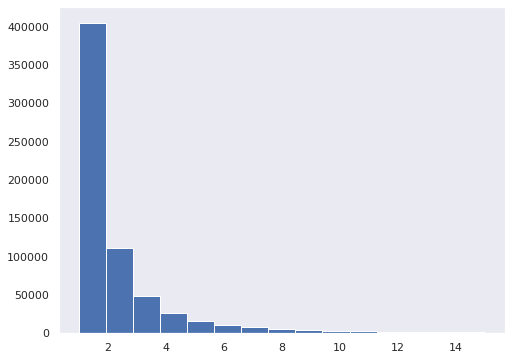

In [16]:
df['user'].value_counts().hist(bins=15, figsize=(8, 6))
plt.grid(False)

## Some users post duplicated posts (maybe more bots)

Subset 'all_columns': 0 (0.00% of total 1,314,520) records are detected as duplicated.
Subset 'date+user+text': 153 (0.01% of total 1,314,520) records are detected as duplicated.
Subset 'user+text': 1,969 (0.15% of total 1,314,520) records are detected as duplicated.
Subset 'id+text': 0 (0.00% of total 1,314,520) records are detected as duplicated.


,all_columns,date+user+text,user+text,id+text
num_duplicates,0.0,1.530000e+02,1.969000e+03,0.0
num_total,1314520.0,1.314520e+06,1.314520e+06,1314520.0
percentage,0.0,1.163923e-02,1.497885e-01,0.0


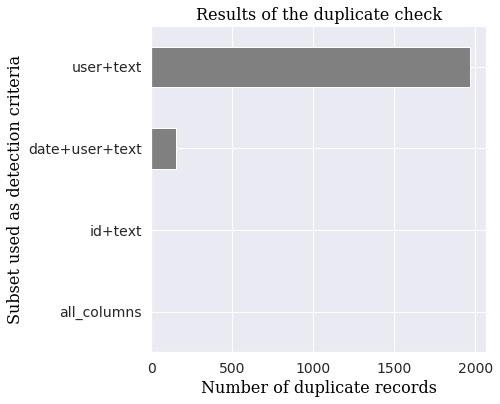

In [17]:
subsets_to_check = {
    'date+user+text': ['date', 'user', 'text'],
    'user+text': ['user', 'text'],
    'id+text': ['ids', 'text']
}

# added columns 'hashtags' and 'handles' are excluded from the check
duplicate_check(df.drop(['hashtags', 'handles'], axis=1), 
                subsets_to_check=subsets_to_check)

In [18]:
mask1 = df.duplicated(subset=['user', 'text'], keep=False)
df.loc[mask1, ['date', 'user', 'text']].sort_values('user').tail(10)

,date,user,text
454515,2009-06-07 18:05:20,zappingzonatica,Nobody's reply my mensagesss snif
990608,2009-05-18 04:57:21,zeroduke,surf city for my sweet zebrina ?
990637,2009-05-18 04:58:50,zeroduke,surf city for my sweet zebrina ?
1385143,2009-06-06 01:56:09,zoliky,How to run Mac OS X on PC (100% compatibility)...
1385191,2009-06-06 01:57:28,zoliky,How to run Mac OS X on PC (100% compatibility)...
810404,2009-04-07 07:30:20,zottarella,Lets Drop ..Ich hatte gerade K'se auf Toast. G...
800632,2009-04-06 23:03:31,zottarella,Lets Drop ..Ich hatte gerade K'se auf Toast. G...
801783,2009-04-07 00:03:33,zottarella,Lets Drop ..Ich hatte gerade K'se auf Toast. G...
871025,2009-05-02 07:12:54,zyozyfounder,"@GabrielRossi this is so brilliant, I'm going ..."
871024,2009-05-02 07:12:54,zyozyfounder,"@GabrielRossi this is so brilliant, I'm going ..."


In [19]:
df = df[~mask1]
print("{0:,} records remaining in the DataFrame.".format(len(df)))

1,311,110 records remaining in the DataFrame.


## Confirmatory duplicate check

Subset 'all_columns': 0 (0.00% of total 1,311,110) records are detected as duplicated.
Subset 'date+user+text': 0 (0.00% of total 1,311,110) records are detected as duplicated.
Subset 'user+text': 0 (0.00% of total 1,311,110) records are detected as duplicated.
Subset 'id+text': 0 (0.00% of total 1,311,110) records are detected as duplicated.


,all_columns,date+user+text,user+text,id+text
num_duplicates,0.0,0.0,0.0,0.0
num_total,1311110.0,1311110.0,1311110.0,1311110.0
percentage,0.0,0.0,0.0,0.0


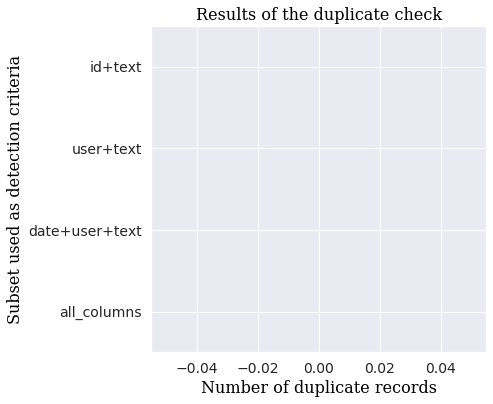

In [20]:
subsets_to_check = {
    'date+user+text': ['date', 'user', 'text'],
    'user+text': ['user', 'text'],
    'id+text': ['ids', 'text']
}

# added columns 'hashtags' and 'handles' are excluded from the check
duplicate_check(df.drop(['hashtags', 'handles'], axis=1), 
                subsets_to_check=subsets_to_check)

## Save results to a .csv file

In [21]:
save_path = data_dir + 'sentiment140_train_nodup.csv'
t = time()
df.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file\n{0}\ntook {1:,.2f} seconds ({2:,.2f} minutes)"
      .format(save_path, elapsed, elapsed / 60))


DataFrame saved to file
../../data/sentiment140/sentiment140_train_nodup.csv
took 7.92 seconds (0.13 minutes)
